# ¿Comprar o alquilar casa? ¿Qué me conviene?
En este ejercicio, se utilizara el algoritmo Gaussian Naive Bayes para decidir si nos conviene Alquilar o Comprar una casa.


# El teorema de Bayes
Es una ecuación que describe la relación de probabilidades condicionales de cantidades estadísticas. En clasificación bayesiana estamos interesados en encontrar la probabilidad de que ocurra una “clase” dadas unas características observadas (datos). Lo podemos escribir como P(Clase|Datos). El teorema de Bayes nos dice cómo lo podemos expresar en términos de cantidades que podemos calcular directamente:

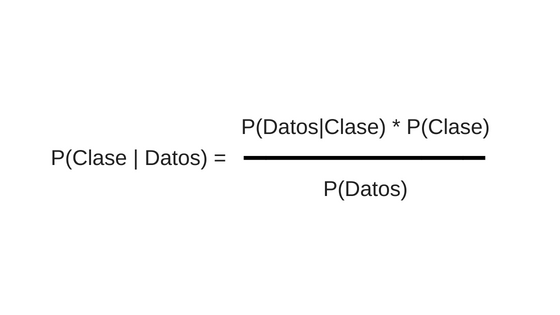


    Clase es una salida en particular, por ejemplo “comprar”
    Datos son nuestras características, en nuestro caso los ingresos, gastos, hijos, etc
    P(Clase|Datos) se llama posterior (y es el resultado que queremos hallar)
    P(Datos|Clase) se llama “verosimilitud” (en inglés likelihood)
    P(Clase) se llama anterior (pues es una probabilidad que ya tenemos)
    P(Datos) se llama probabilidad marginal
    
Si estamos tratando de elegir entre dos clases como en nuestro caso “comprar” ó “alquilar”, entonces una manera de tomar la decisión es calcular la tasa de probabilidades a posterior:


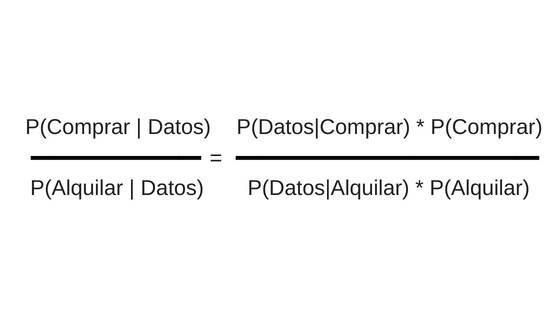

con esta maniobra, nos deshacemos del denominador de la ecuación anterior P(Datos) el llamado “probabilidad marginal”.

# Clasificador Gaussian Naive Bayes
Uno de los tipos de clasificadores más populares es el llamado en inglés Gaussian Naive Bayes Classifier. Veamos cómo es su fórmula para comprender este curioso nombre: aplicaremos 2 clases (comprar, alquilar) y tres características: ingresos, ahorros e hijos.

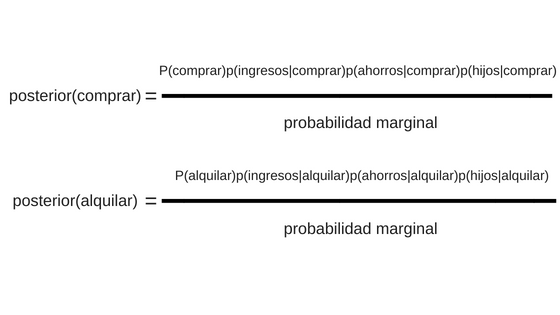


Posterior de comprar es lo que queremos hallar: P(comprar|datos).

Explicacion:

* P(comprar) es la probabilidad que ya tenemos. Es sencillamente el número de veces que se selecciona comprar =1 en nuestro conjunto de datos, dividido el total de observaciones. En nuestro caso (luego lo veremos en Python) son 67/202
* p(ingresos|comprar)p(ahorros|comprar)p(hijos|comprar) es la verosimilitud. Los nombres Gaussian y Naive (ingenuo) del algoritmo vienen de dos suposiciones:
1 Asumimos que las características de la verosimilitud no estan correlacionada entre ellas. Esto seria que los ingresos sean independientes a la cantidad de hijos y de los ahorros. Como no es siempre cierto y es una suposición ingenua es que aparece en el nombre “naive bayes”
2 Asumimos que el valor de las características (ingresos, hijos, etc) tendrá una distribución normal (gaussiana). Esto nos permite calcular cada parte p(ingresos|comprar) usando la función de probabilidad de densidad normal.
* Probabilidad marginal muchas veces es difícil de calcular, sin embargo, por la ecuación que vimos más arriba, no la necesitaremos para obtener nuestro valor a posterior. Esto simplifica los cálculos.rior. Esto simplifica los cálculos.Esto simplifica los cálculos.


In [46]:
# Librearia a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

# Importar datos de entrada
Se utiliza los datos del archivo: comprar_alquilar.csv, cuyas caracteristicas son:
* ingresos: los ingresos de la familia mensual
* gastos comunes: pagos de luz, agua, gas, etc mensual
* pago coche: si se está pagando cuota por uno o más coches, y los gastos en combustible, etc al mes.
* gastos_otros: compra en supermercado y lo necesario para vivir al mes
* ahorros: suma de ahorros dispuestos a usar para la compra de la casa.
* vivienda: precio de la vivienda que quiere comprar esa familia
* estado civil:
    - 0-soltero
    - 1-casados
    - 2-divorciados
* hijos: cantidad de hijos menores y que no trabajan.
* trabajo:
    - 0-sin empleo
    - 1-autónomo (freelance)
    - 2-empleado
    - 3-empresario
    - 4-pareja: autónomos
    - 5-pareja: empleados
    - 6-pareja: autónomo y asalariado
    - 7-pareja:empresario y autónomo
    - 8-pareja: empresarios los dos o empresario y empleado
* comprar:
    - 0-No comprar
    - 1-Comprar (esta será nuestra columna de salida, para aprender)

Algunos supuestos para el problema formulado:
* Está pensado en Euros pero podría ser cualquier otra moneda
* No tiene en cuenta ubicación geográfica, cuando sabemos que dependerá mucho los precios de los inmuebles de distintas zonas
* Se supone una hipoteca fija a 30 años con interés de mercado “bajo”.

Con esta información, queremos que el algoritmo aprenda y que como resultado podamos consultar nueva información y nos dé una decisión sobre comprar (1) o alquilar (0) una casa.


In [48]:
dataframe = pd.read_csv(r"comprar_alquilar.csv")
dataframe.head(10)


,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


# Visualizar datos
A continuacion se visualiza la muestras de comprar o alquilar:

In [52]:
dataframe.groupby('comprar').size()

comprar
0    135
1     67
dtype: int64

Visualizamos los datos utilizando histogramas de las caracateristicas quitando la variable objetivo

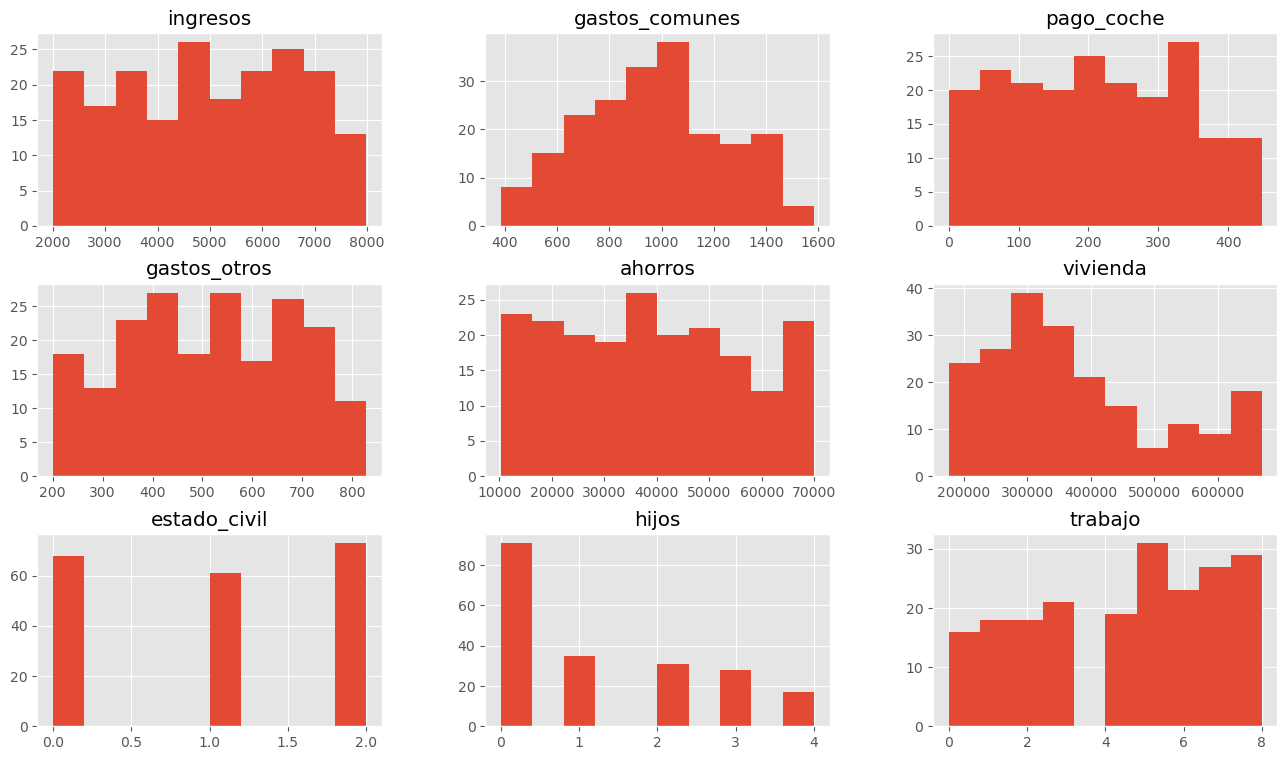

In [57]:
dataframe.drop(['comprar'], axis=1).hist()
plt.show()

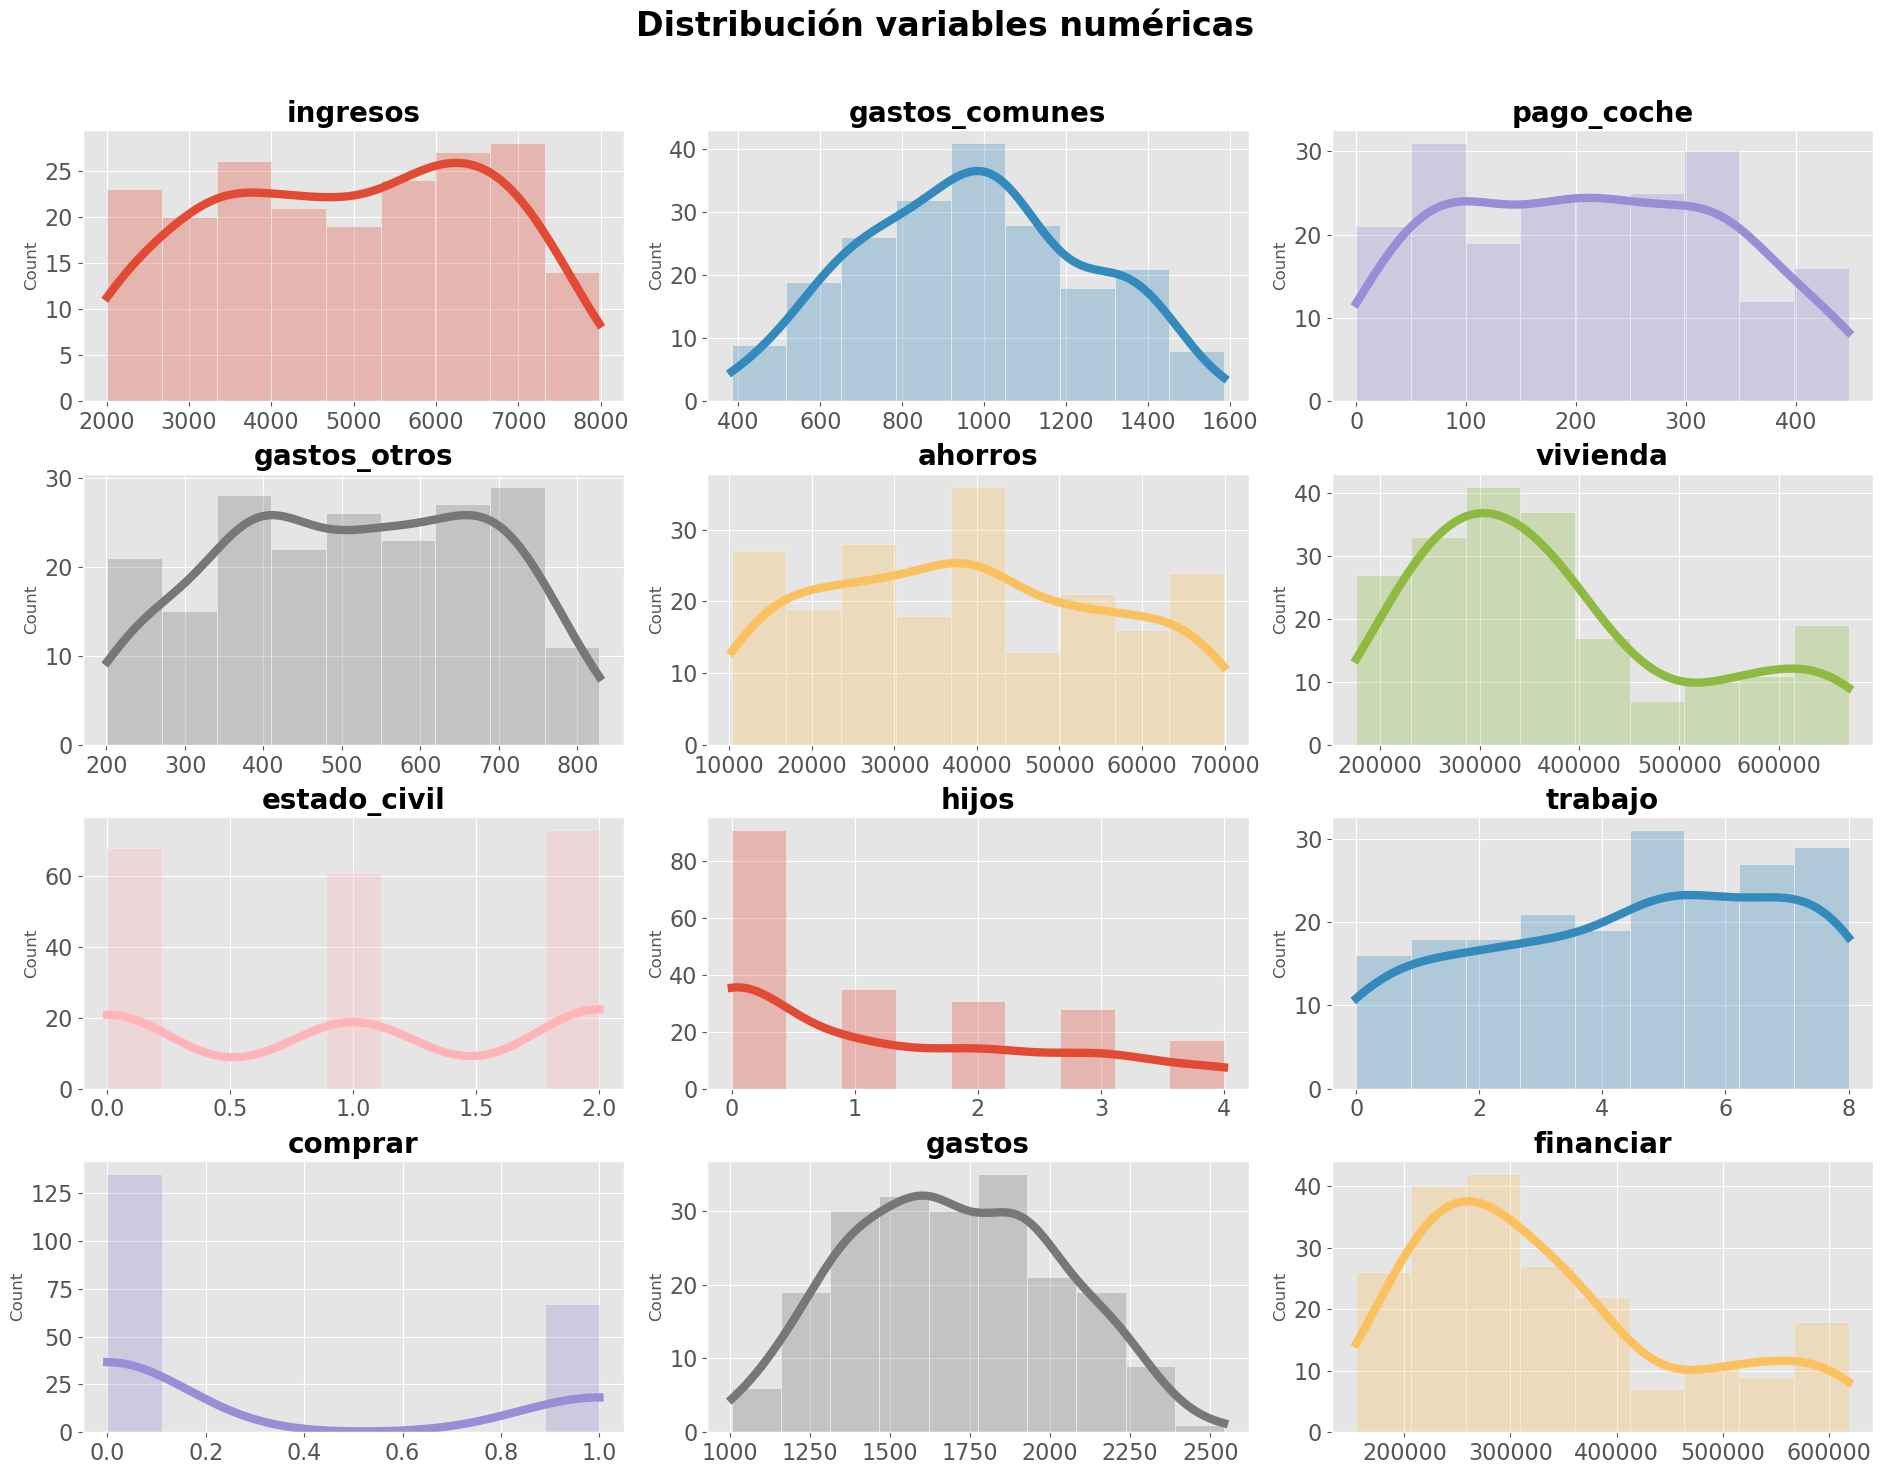

In [113]:
# Histograma de todas los atributos
# Ajustando número de subplots en función del número de columnas
# Tomado como referencia a: https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(19, 15))
axes = axes.flat
columnas_numeric = dataframe.select_dtypes(include=['float64', 'int']).columns
for i, colum in enumerate(columnas_numeric):
    sb.histplot(
        data    = dataframe,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 6},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 16)
    axes[i].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 24, fontweight = "bold");

# Preparar datos de entrada
Luego de analizar los datos podemos por ejemplo agrupar los diversos gastos. Ademas se creara una columna llamada "financiar" que sera la resta del precio de la vivienda con los ahorros de la familia


In [60]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1).head(10)

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,50000,400000,0,2,2,1,1600,350000
1,6745,43240,636897,1,3,6,0,1496,593657
2,6455,57463,321779,2,1,8,1,1926,264316
3,7098,54506,660933,0,0,3,0,1547,606427
4,6167,41512,348932,0,0,3,1,1606,307420
5,5692,50875,360863,1,4,5,1,1247,309988
6,6830,46761,429812,1,1,5,1,1952,383051
7,6470,57439,606291,0,0,1,0,1856,548852
8,6251,50503,291010,0,0,3,1,2030,240507
9,6987,40611,324098,2,1,7,1,1755,283487


Ahora vemos la informacion estadistica de los datos

In [63]:
reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1)
reduced.describe()

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


# Feature Selection
A continuacion se seleccinan las caracteristicas de entrada


## Correlacion de columnas

<Axes: title={'center': 'Pearson Correlation of Features'}>

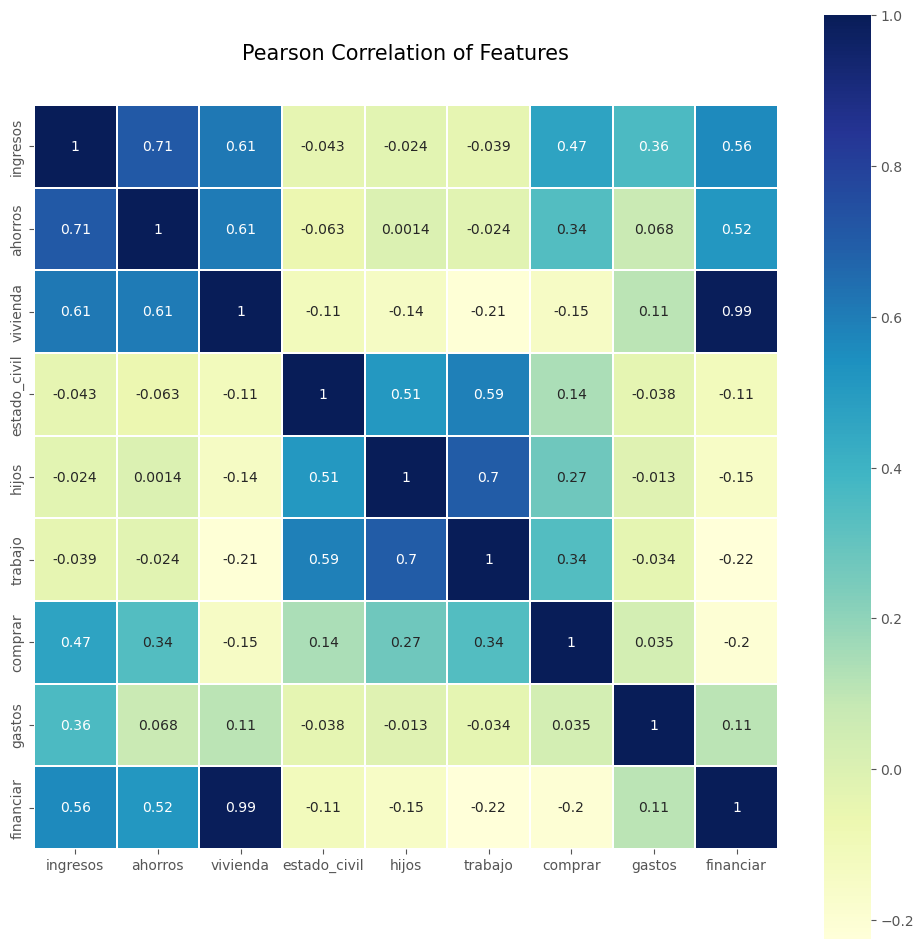

In [117]:
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(reduced.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap="YlGnBu", linecolor='white', annot=True)

# Nota
Para mejorar los resultados con este algoritmo, en lugar de utilizar las 11 columnas de datos de entrada que tenemos, vamos a utilizar la Clase de SkLearn llamada SelectKBest para seleccionar las 5 mejores caracteristicas a utilizar.

In [121]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar'], dtype='object')


Ahora veamos la correlacion entre estas 5 mejores Features, en lugar de las 11 caracteristicas. Es decir seleccionamos las que mas aportan al momento de clasificar.

<Axes: title={'center': 'Pearson Correlation of Features'}>

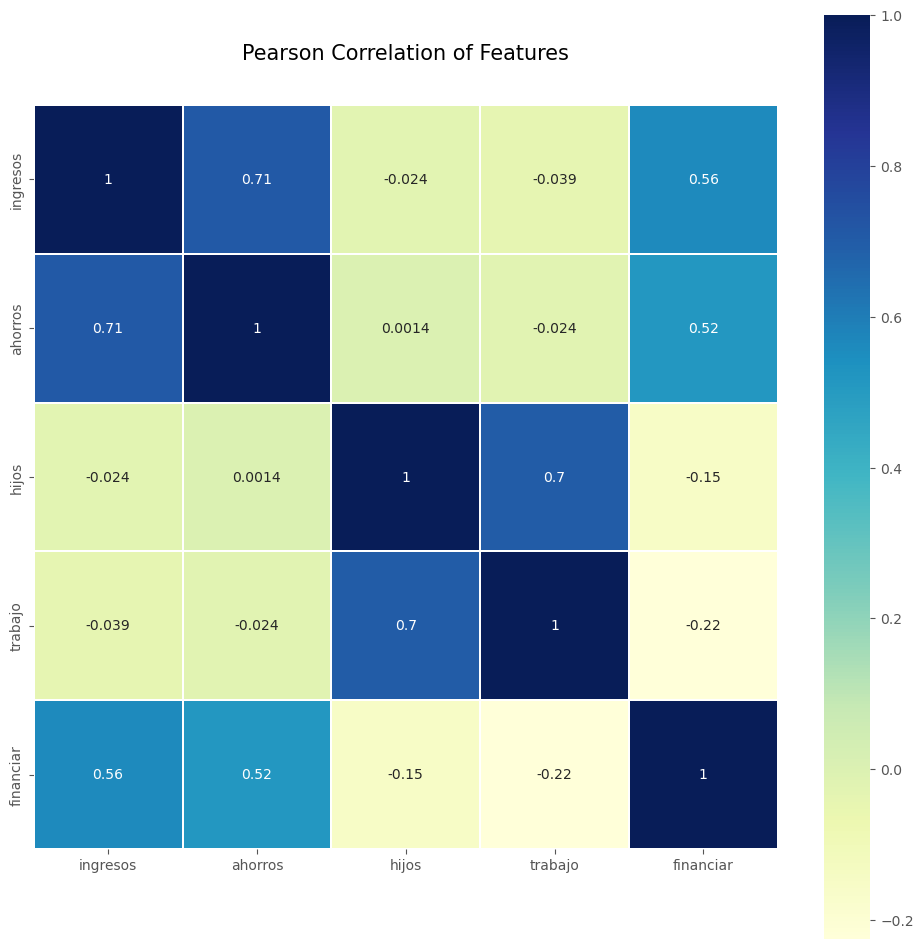

In [123]:
used_features =X.columns[selected]

plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap="YlGnBu", linecolor='white', annot=True)

Vemos que en general estan poco correlacionados, sin embargo tambien tenemos 2 valores de 0.7, se espera que el algoritmo sea lo suficientemente "naive" para obtener buenos resultados.

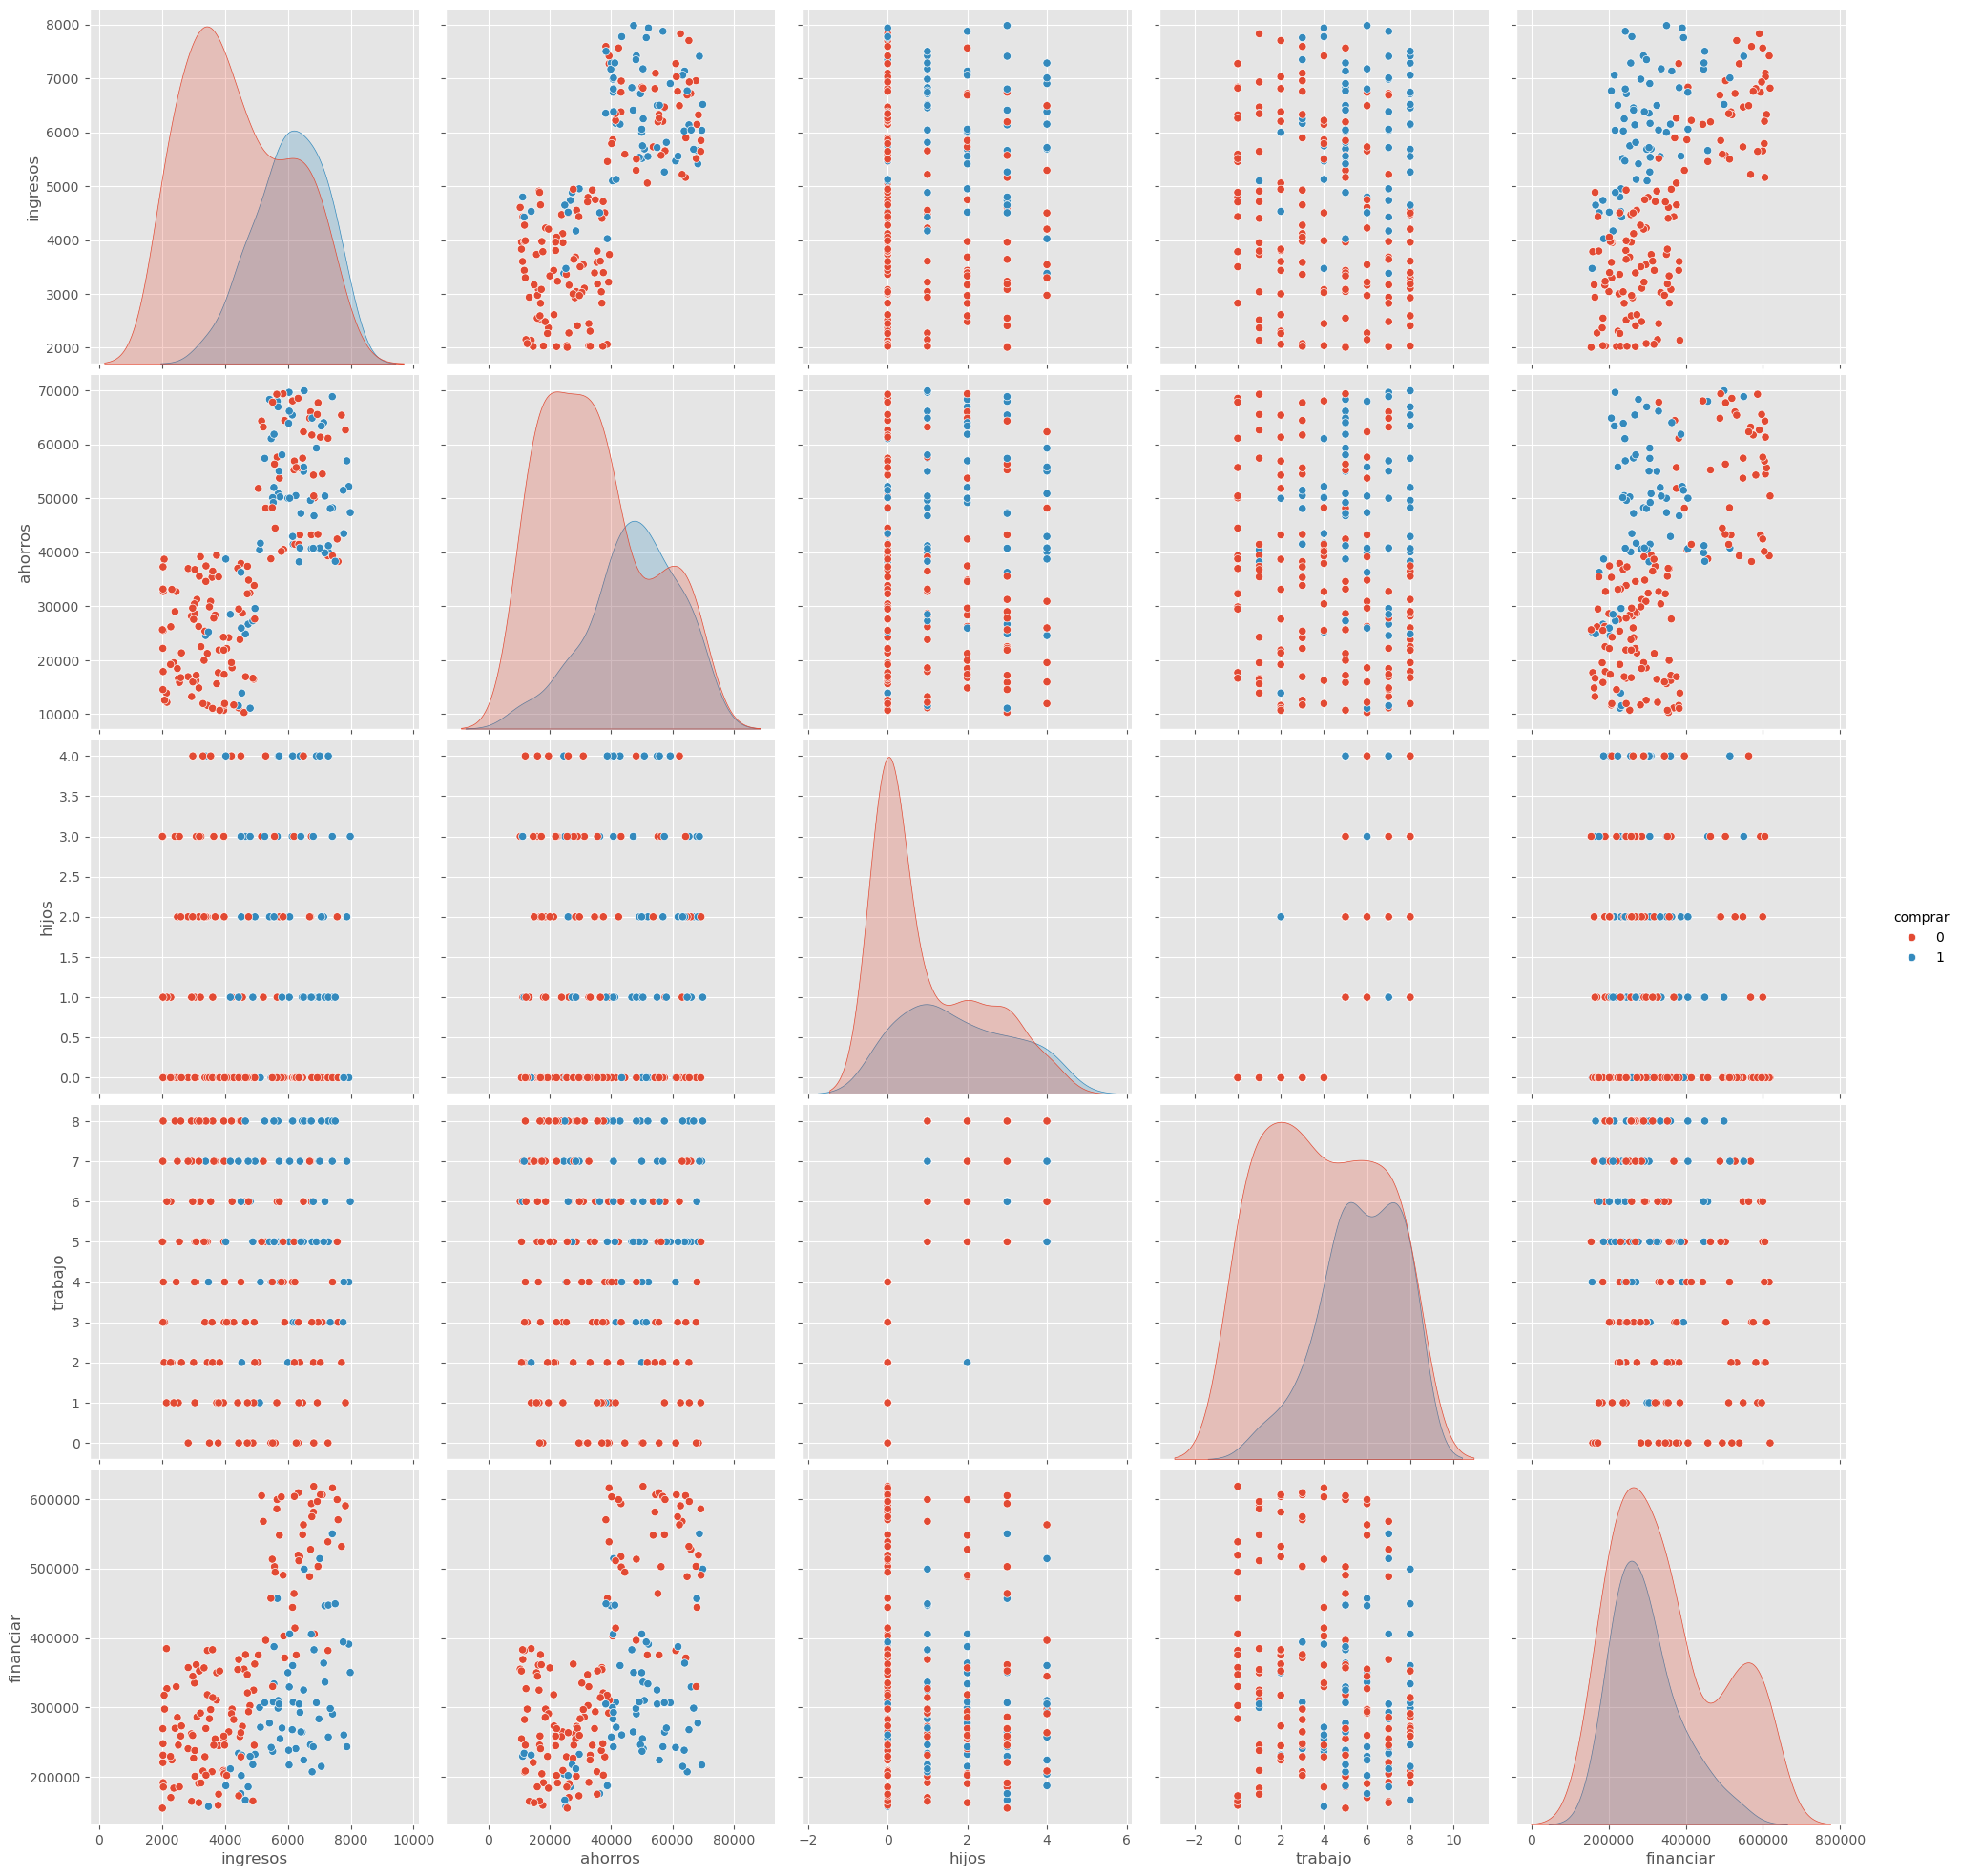

In [77]:
sb.pairplot(dataframe, hue='comprar',height=4,vars=used_features,kind='scatter')

Vamos a graficar 2 de las Features

[(2000.0, 9000.0), (100000.0, 700000.0)]

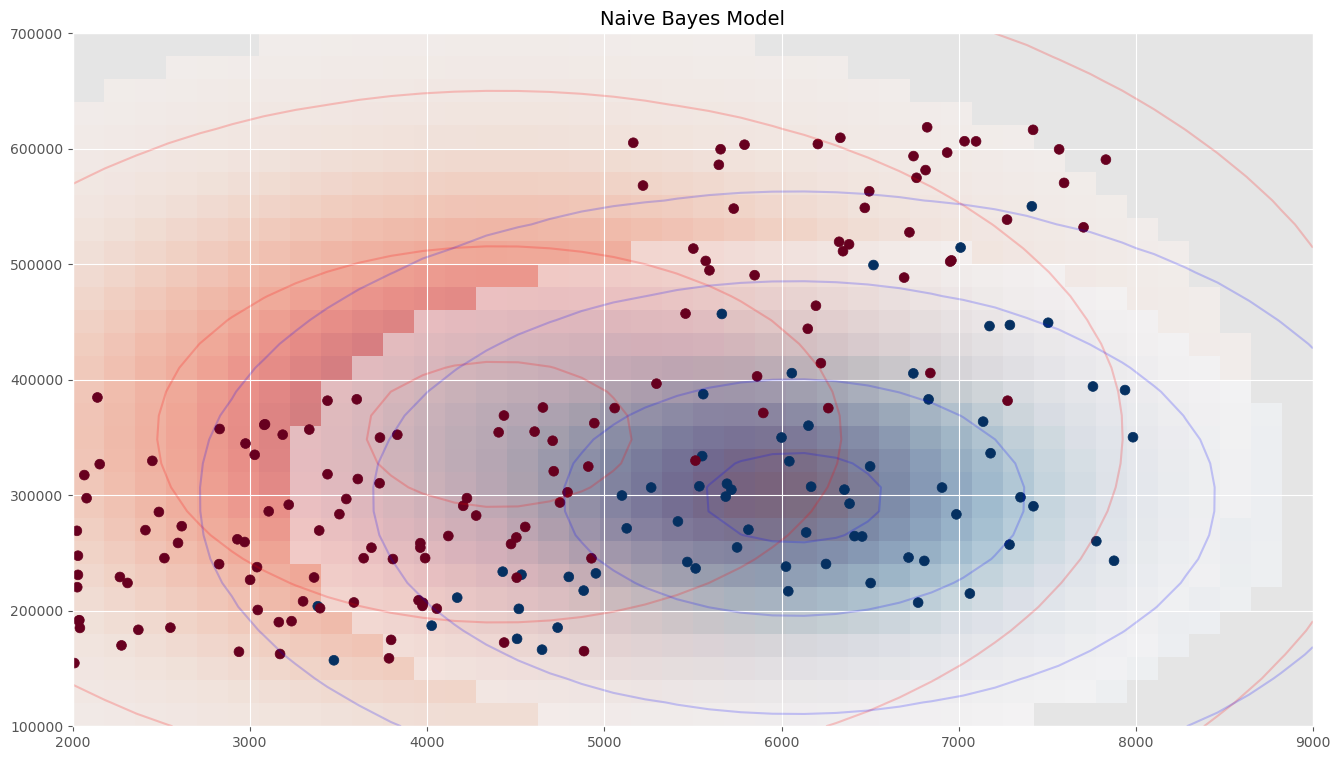

In [80]:
used_features2 =[
    "ingresos",
    "financiar"
]
X=dataframe[used_features2].values
y=dataframe["comprar"]

fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (2000, 9000)
ylim = (100000, 700000)

xg = np.linspace(xlim[0], xlim[1], 40)
yg = np.linspace(ylim[0], ylim[1], 30)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

Se puede observar que cuantos más ingresos tiene la familia y menor es la cantidad a financiar, mejora la opción de Comprar (en azul). De otra manera, convendrá alquilar (rojo)

# Crear el modelo Gaussian Naive Bayes
Dividimos en un set de entrenamiento y un set de test con el 20% de entradas

In [88]:
# Split dataset in training and test datasets
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=6) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]

# Entrenar el modelo

In [125]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])


C:\Users\evale\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


# Resultados

In [98]:
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test)))

Precisión en el set de Entrenamiento: 0.87
Precisión en el set de Test: 0.90


C:\Users\evale\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
C:\Users\evale\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [100]:
# Print Test results
print("Total de Muestras en Test: {}\nFallos: {}"
      .format(
          X_test.shape[0],
          (y_test != y_pred).sum()
))

Total de Muestras en Test: 41
Fallos: 4


In [102]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[24  0]
 [ 4 13]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      0.76      0.87        17

    accuracy                           0.90        41
   macro avg       0.93      0.88      0.89        41
weighted avg       0.92      0.90      0.90        41



# Realizar pruebas con nuevas predicciones

In [105]:
# ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[2000,        5000,     0,       5,         200000],
                   [6000,        34000,    2,       5,         320000] ]))
#Resultado esperado 0-Alquilar, 1-Comprar casa

[0 1]
